In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.stats import mode
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight


## Import Dataset

In [2]:
train_df = pd.read_csv('Train.csv')
test_df =pd.read_csv('Test.csv')
sub = pd.read_csv('SampleSubmission.csv')

In [3]:
test_df.head()

,id,REFLEC1,REFLEC2,REFLEC3,REFLEC4,REFLEC5,REFLEC6,REFLEC7,PCA1,PCA2,...,LON1,DOSEL1,VVR1,VHR1,VHVVR1,VVD1,VHD1,VHVVD1,MNDWI1,NDTI1
0,id_utdshhcma9,125.0,174.0,429.0,365.0,3449.0,1819.0,874.0,15658.46289,1138.856689,...,-105.159805,7.0,0.180058,0.045851,0.254506,0.150816,0.035861,0.237626,-0.618327,0.350910
1,id_wpr03x91k8,110.0,129.0,363.0,193.0,3113.0,1265.0,485.0,15037.56445,714.649597,...,-105.162437,24.0,0.258292,0.058265,0.225489,0.227427,0.071647,0.314893,-0.554054,0.445714
2,id_ihn04pau10,141.0,159.0,338.0,312.0,2013.0,1228.0,600.0,14677.36621,80.350555,...,-104.746994,26.0,0.170567,0.046422,0.272002,0.159551,0.042044,0.263349,-0.568327,0.343545
3,id_dujctwctkv,247.0,109.0,368.0,222.0,3613.0,1747.0,755.0,15594.74512,1190.041992,...,-105.145180,0.0,0.230309,0.063892,0.277296,0.192240,0.049381,0.256738,-0.652009,0.396483
4,id_fjf3v7c0h6,215.0,271.0,579.0,457.0,3145.0,1715.0,870.0,15646.23828,789.847656,...,-104.731415,0.0,0.144379,0.040683,0.281584,0.071042,0.012255,0.172266,-0.495205,0.326886


In [4]:
less_count_classes = [88, 30]
train_df = train_df[~train_df['Target'].isin(less_count_classes)]
train_df.reset_index(drop=True, inplace=True)

##### Label encode the Target variables

In [5]:
all_targets = train_df['Target'].unique().tolist()
le = LabelEncoder()
le.fit(all_targets)
le.classes_
encoded_classes = le.transform(all_targets) 
train_df['encoded_target'] = [le.transform([value])[0] for value in train_df['Target']]


#### Feature Engineering

#### Reflectance column meaning

1. Band 1 Coastal Aerosol (0.43 - 0.45 µm) 30 m
2. Band 2 Blue (0.450 - 0.51 µm) 30 m
3. Band 3 Green (0.53 - 0.59 µm) 30 m
4. Band 4 Red (0.64 - 0.67 µm) 30 m
5. Band 5 Near-Infrared (0.85 - 0.88 µm) 30 m
6. Band 6 SWIR 1(1.57 - 1.65 µm) 30 m
7. Band 7 SWIR 2 (2.11 - 2.29 µm) 30 m



#### Polarization (Dry and Wet Season)

1. VV(Vertical-Vertical) - VV (Vertical-Vertical) polarization tend to interact more strongly with objects that have a vertical orientation or components, like tall plants, tree trunks, buildings, and other structures with a significant vertical profile.

2. VH(Vertical-Horizontal) - It can help distinguish between dense, heterogeneous vegetation (like forests) and simpler, smoother land covers (like grasslands or water bodies).

3. VHVR (Vertical-Horizontal-Vertical-Vertical-Ratio) - VHR1 divided by VVR1	(VHR1/VVR1)


#### PCA 

I have no idea how the PCA values were derived. But since PCA1 is highly correlated with 'REFLEC6' and 'REFLEC7', my guess is that it was derived from Reflectance values. I however tested the PCA with the reflectance columns but the values weren't the same.
My best guess is the PCA was calculated on all the bands, and then we were only given 7 bands from the bands it was calculated from.


#### WorldCLim BIolcim Variables

1. PRECIPAN1 - Annual precipitation	-  total amount of precipitation (rainfall, snow, sleet, etc.) that falls in a specific area over the course of a year. It is a key indicator of the moisture availability in a region.

2. PRECIPWET1 - Precipitation of wettest month	

3. PRECIPDRY1 - Precipitation of driest month

4. PRECIPVAR1 - Precipitation seasonality (Coefficient of Variation) - A low coefficient of variation indicates low seasonality, meaning precipitation is relatively stable throughout the year. This might be seen in regions with more consistent rainfall. 

5. 

'TMPMAN1', 'TMPMAX1', 'TMPMIN1',



IDEAS

1. Noise Detection Using Ensemble Learning
Ensemble methods like Random Forest or XGBoost can help detect noisy labels:
Train an ensemble of models (bagging, boosting, or stacking) on subsets of the data.
If the predictions across the ensemble members vary significantly for a particular sample, it is likely that the sample has a noisy label.
Flag samples with high disagreement or incorrect predictions for potential noise.


2. Clustering-based Methods
Clustering techniques can also be used to identify noisy labels. The intuition is that noisy labels might form outliers or belong to a different cluster than their clean counterparts:
Apply clustering algorithms like K-Means or DBSCAN on the features of your data.
Compare the cluster assignments with the labels: samples whose labels are inconsistent with the majority in their cluster are likely to be noisy.
You can either discard these noisy samples or relabel them.


3. Clustering method using the latitude and longitude


4. Use Lazy Predict - https://github.com/shankarpandala/lazypredict

NOTES
 
1. Suspicious ids using dbscan -- ['id_zgxjio9glq', 'id_n0wt8xp96q',
 'id_osw0s78zfg',
 'id_udgxwwknb5',
 'id_jztbwyw3uj']


2. TMPMIN1 and TMPMAN1 are about 95% correlated

3. ELEV1 is 96% correlated to TMPMIN1

4. Some indices are highly correlated to each other. One way to resolve this will be to use one feature in a model and the second feature in another second model (NDTI1 and NDVI2, TRI1 and PEND1, ROUGH1 and PEND1,   )

5. PCA1 is highly correlated with 'REFLEC6' and 'REFLEC7'

6. About 32 

##### Define columns

1.  remove the Lat and Lon columns in the dataset

#### Convert Polarization columns to decibels

In [6]:
polar_cols = [col for col in train_df.columns if 'vv' in col.lower() or 'vh' in col.lower() ]

for col in polar_cols:
    train_df[f'db_{col}'] = 10 * np.log10(train_df[col])
    test_df[f'db_{col}'] = 10 * np.log10(test_df[col])


#### Some Statistical Ideas

In [7]:
#### dividing reflectance 4 by 7 ---------------------------------worked
train_df['REFLEC4_div_7'] = train_df['REFLEC4'] / train_df['REFLEC7']  


# # max between the two columns ---------------------------------worked
reflect_7 = np.array(train_df['REFLEC7'].tolist())
reflect_4 = np.array(train_df['REFLEC4'].tolist())
train_df['max_7_and_4'] = np.maximum(reflect_7, reflect_4)

# reflect_7 = np.array(test_df['REFLEC7'].tolist())
# reflect_4 = np.array(test_df['REFLEC4'].tolist())
# test_df['max_7_and_4'] = np.maximum(reflect_7, reflect_4)

# green chlorophyll index  ρNIR / ρgreen – 1
train_df['CI_green'] = (train_df['REFLEC5']) / (train_df['REFLEC3'] - 1)

# red chlorophyll index CI red-edge = ρNIR/ρred_edge – 1 
train_df['CI_red'] = (train_df['REFLEC5']) / (train_df['REFLEC4'] - 1)


# Improved Modified Chlorophyll Absorption Ratio Index (MCARI)
# Index = ((VNIR - Red)-0.2*(VNIR - Green))*(VNIR / Red)
train_df['MCARI'] = ((train_df['REFLEC5'] - train_df['REFLEC4']) - 0.2 * (train_df['REFLEC5'] - train_df['REFLEC3'])) * (train_df['REFLEC5'] / train_df['REFLEC4'])


# New Index to Soil Organic Carbon Mapping 
train_df['soc_index'] = (train_df['REFLEC2'] / (train_df['REFLEC4'] * train_df['REFLEC3'])) 


# Normalized difference water index ---------------------------------worked
# NDWI = (Green - NIR) / (Green + NIR) 
train_df['ndwi'] =  (train_df['REFLEC3'] - train_df['REFLEC5']) / (train_df['REFLEC3'] + train_df['REFLEC5'])
test_df['ndwi'] =  (test_df['REFLEC3'] - test_df['REFLEC5']) / (test_df['REFLEC3'] + test_df['REFLEC5'])



# Moisture index
# index = B11 / B08;
train_df['moisture_index'] = train_df['REFLEC7'] / train_df['REFLEC5']


# NDII (Normalized difference Infrared Index)
# (B08 - B11) / (B08 + B11);
train_df['NDII'] = (train_df['REFLEC5'] - train_df['REFLEC7']) / (train_df['REFLEC5'] + train_df['REFLEC7'])



#### Filter Columns

In [9]:
not_needed_cols = ['id', 'Target', 'encoded_target', 'LAT2', 'LON1', 'fold']
train_columns = [col for col in train_df.columns if col not in not_needed_cols and col not in polar_cols]

print(train_columns)

['REFLEC1', 'REFLEC2', 'REFLEC3', 'REFLEC4', 'REFLEC5', 'REFLEC6', 'REFLEC7', 'PCA1', 'PCA2', 'PCA3', 'NDVI1', 'NDVI2', 'NDVI3', 'NDVI4', 'ELEV1', 'PEND1', 'ILUM1', 'TOPOIND1', 'ROUGH1', 'TRI1', 'COFS1', 'TMPMAN1', 'TMPMAX1', 'TMPMIN1', 'TVARDAY1', 'PRECIPAN1', 'PRECIPWET1', 'PRECIPDRY1', 'PRECIPVAR1', 'MARTONNE1', 'DOSEL1', 'MNDWI1', 'NDTI1', 'db_VVR1', 'db_VHR1', 'db_VHVVR1', 'db_VVD1', 'db_VHD1', 'db_VHVVD1', 'REFLEC4_div_7', 'max_7_and_4', 'CI_green', 'CI_red', 'MCARI', 'soc_index', 'ndwi', 'moisture_index', 'NDII']


In [10]:
len(train_df.Target.unique().tolist())

43

## Modelling



In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
import lightgbm as lgb


fold = 4
skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)
X = train_df[train_columns]
y = train_df['encoded_target']


# set fold column
train_df['fold'] = None

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    train_df.loc[test_index, 'fold'] = i

log_loss_value = 0
test_predictions = []

for i in range(fold):
    train = train_df[train_df['fold']!= i]
    val = train_df[train_df['fold']== i]

    X_train = train[train_columns]
    y_train = train['encoded_target']

    X_test = val[train_columns]
    y_test =  val['encoded_target']


    train_sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

    train_data = lgb.Dataset(
        X_train,
        label=y_train,
        weight=train_sample_weights,
    )

    validation_sample_weights = compute_sample_weight(
        class_weight="balanced",
        y=y_test,
    )

    validation_data = lgb.Dataset(X_test, label=y_test, weight=validation_sample_weights)

    param  = {
   'n_estimators':2500,'objective': 'multiclass',
    'learning_rate':0.03, 'num_leaves':15,'reg_alpha':1,'reg_lambda':7,
    'max_depth':9,
    'random_state':42,'verbose': -1,
     "num_class": 43
     }


    num_round = 5000
    early_stopping_rounds = 100

    model = lgb.train(
        param,
        train_data,
        num_round,
        valid_sets=[validation_data],
        callbacks=[lgb.early_stopping(stopping_rounds=early_stopping_rounds)],
    )


    pred_prob = model.predict(X_test)

    # evaluation of model
    log_loss_value += log_loss(y_test, pred_prob)
    print(" ")
    print(f'log loss for fold {i+1}: {log_loss(y_test, pred_prob)}')
    print(" ")

    test prediction
    test_preds = model.predict(test_df[train_columns])
    test_predictions.append(test_preds)


print(f'CV Log_loss: {log_loss_value/fold}')


#### Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

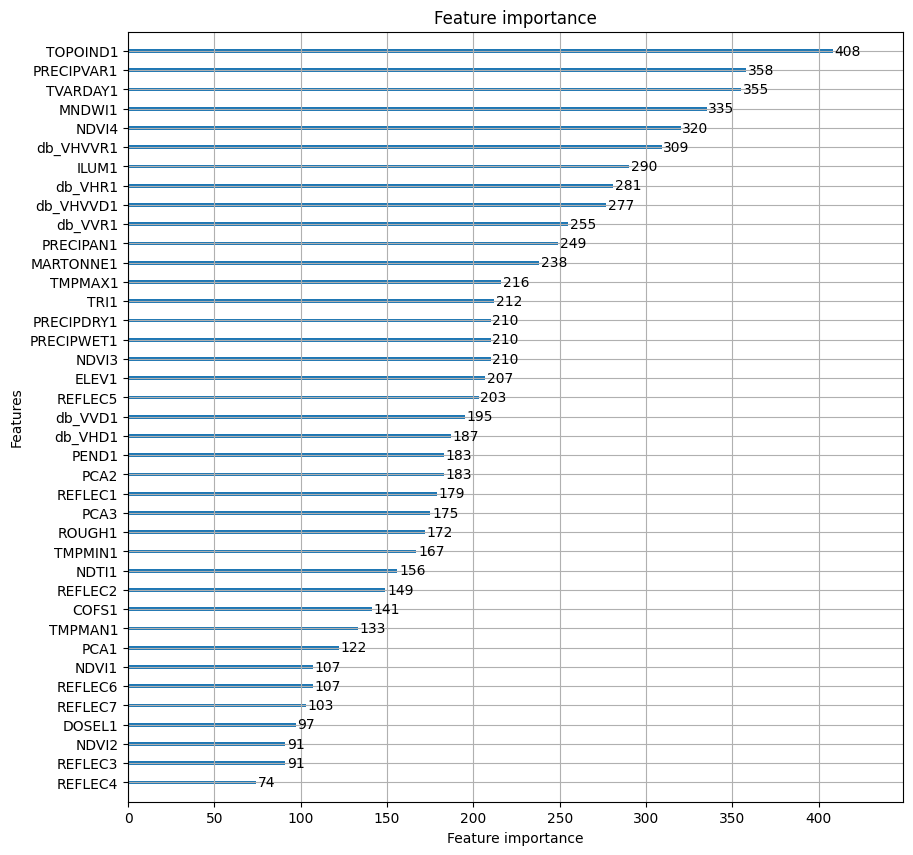

In [1258]:
lgb.plot_importance(model, figsize=(10, 10))

#### Submission

In [1259]:
# average fold prediction probabilities across the five folds
mean_predictions = (np.array(test_predictions).mean(axis=0))
# get the name of the original columns back
original_cols = [le.inverse_transform([i])[0] for i in range(38)]
# create the submission dataframe
sub_columns = ['Target_' + str(i) for i in range(125)]
id_list = test_df.id.tolist()

submission_df = pd.DataFrame(columns= ['id'] + sub_columns)
submission_df['id'] = id_list

for col in submission_df.columns:
    if col != 'id':
        submission_df.loc[:, col] = 0

# loop through the test dataframe rows
for i in range(test_df.shape[0]):
    # get the predictions for that row
    # id_predictions = test_preds[i]   # using a single fold predictions
    id_predictions = mean_predictions[i] # using mean predictions
    # loop through the predicted probabilites for each vegetation class
    for p,  pred in enumerate(id_predictions):
        # get the original class name
        original_class_name = le.inverse_transform([p])[0]
        # create the column name
        column_name = 'Target_' + str(original_class_name) 
        # attach the original class name to target column in submission_df
        submission_df.loc[i, column_name] = pred

submission_df.head()

,id,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Target_8,...,Target_115,Target_116,Target_117,Target_118,Target_119,Target_120,Target_121,Target_122,Target_123,Target_124
0,id_utdshhcma9,0,0.02449,0.016846,0.01981,0.023927,0.016518,0,0,0,...,0,0,0,0.015599,0,0,0,0,0.018579,0
1,id_wpr03x91k8,0,0.025993,0.016506,0.022715,0.021901,0.023526,0,0,0,...,0,0,0,0.016165,0,0,0,0,0.020266,0
2,id_ihn04pau10,0,0.021443,0.016404,0.017124,0.021022,0.017381,0,0,0,...,0,0,0,0.016132,0,0,0,0,0.01913,0
3,id_dujctwctkv,0,0.026044,0.016794,0.021825,0.034511,0.021352,0,0,0,...,0,0,0,0.01555,0,0,0,0,0.018413,0
4,id_fjf3v7c0h6,0,0.041004,0.021493,0.03964,0.024081,0.016269,0,0,0,...,0,0,0,0.014997,0,0,0,0,0.015692,0


In [1261]:
real_submission = sub[['id']].merge(submission_df, on='id')
real_submission.to_csv('lightgbm_3.649502.csv', index=False)